<a href="https://colab.research.google.com/github/HeshanNavindu-7/oilspill-detection/blob/main/oilspill_xception_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install opendatasets visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 17.4 MB/s eta 0:00:00


In [2]:
# Import modules
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import opendatasets as od

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Download dataset
od.download("https://www.kaggle.com/datasets/heshannavindu/oilspill-nooilspill-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/heshannavindu/oilspill-nooilspill-dataset


100%|██████████| 82.8M/82.8M [00:00<00:00, 1.21GB/s]

In [11]:
dataset_dir = "/content/oilspill-nooilspill-dataset/oilspill_dataset"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [12]:
# Focal Loss
import tensorflow.keras.backend as K
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return loss_fn

In [13]:

# Data generators
target_size = (224, 224)
batch_size = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    validation_split=0.2
)



In [ ]:
train_dir = '/content/oilspill-nooilspill-dataset/oilspill_dataset/train'
test_dir = '/content/oilspill-nooilspill-dataset/oilspill_dataset/test'

In [14]:
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size,
    class_mode='binary', subset='training')

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size,
    class_mode='binary', subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size,
    class_mode='binary', shuffle=False)


Found 277 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


In [15]:

# Xception Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base
for layer in base_model.layers:
    layer.trainable = False


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:

# Compile
model.compile(optimizer=Adam(1e-3), loss=focal_loss(), metrics=['accuracy'])


In [17]:
# Train (stage 1)
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6)]

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=15, steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen), callbacks=callbacks)

# Fine-tune last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4), loss=focal_loss(), metrics=['accuracy'])

history_fine = model.fit(train_gen, validation_data=val_gen,
                         epochs=10, steps_per_epoch=len(train_gen),
                         validation_steps=len(val_gen), callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6340 - loss: 0.1805 - val_accuracy: 0.8529 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8883 - loss: 0.0285 - val_accuracy: 0.8235 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8718 - loss: 0.0278 - val_accuracy: 0.8676 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8895 - loss: 0.0204 - val_accuracy: 0.8824 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9213 - loss: 0.0205 - val_accuracy: 0.8529 - val_loss: 0.0413 - learning_rate: 0.0010
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9286 - loss: 0.0152 - val_accuracy: 0.8824 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9548 - loss: 0.0077 - val_accuracy: 

In [18]:
# Save model
model.save("oil_spill_detection_xception.h5")

26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step
              precision    recall  f1-score   support

     nospill       1.00      0.98      0.99       103
    oilspill       0.98      1.00      0.99        98

    accuracy                           0.99       201
   macro avg       0.99      0.99      0.99       201
weighted avg       0.99      0.99      0.99       201



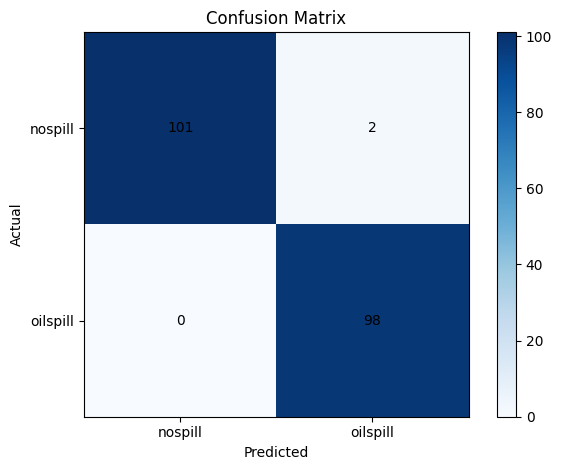

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
test_gen.reset()
y_pred = (model.predict(test_gen) > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Report
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks([0,1], test_gen.class_indices.keys())
plt.yticks([0,1], test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.colorbar()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


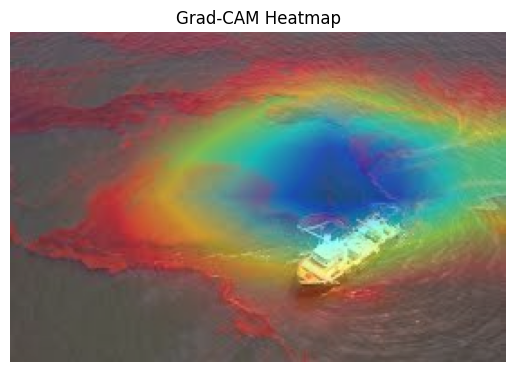

In [28]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

def get_gradcam_heatmap(model, img_array, layer_name='block14_sepconv2_act'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    heatmap = get_gradcam_heatmap(model, img_array)
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img.astype(np.uint8), 0.6, heatmap_color, 0.4, 0)
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.axis('off')
    plt.title('Grad-CAM Heatmap')
    plt.show()

# Example use
display_gradcam("/content/images (12).jfif", model)


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/oil_spill_detection_xception.h5')

# Function to preprocess and load an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Function to make prediction
def predict_image(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    return prediction[0][0], prediction

# Path to the image to be checked
img_path = '/content/137620038_5292932434058195_8513094665018145978_n.jpg'

# Make a prediction
prediction_prob, prediction = predict_image(model, img_path)

# Print the result and accuracy
if prediction_prob >= 0.5:
    print("The image is predicted to be an oil spill image with {:.2f}% confidence.".format(prediction_prob * 100))
else:
    print("The image is predicted to be a no spill image with {:.2f}% confidence.".format((1 - prediction_prob) * 100))

# Optional: Display the image
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Prediction: {"Oil Spill" if prediction_prob >= 0.5 else "No Spill"} (Confidence: {prediction_prob:.2f})')
plt.axis('off')
plt.show()

TypeError: string indices must be integers, not 'str'

In [23]:
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - \
               tf.keras.backend.mean((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return loss_fn

# ✅ Load model with custom_objects
model = tf.keras.models.load_model('/content/oil_spill_detection_xception.h5',
                                   custom_objects={'loss_fn': focal_loss()})


In [24]:
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.2f}')


26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9829 - loss: 0.0049
Test Accuracy: 0.99


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
🌊 The image is predicted to be a NO SPILL with 64.72% confidence.


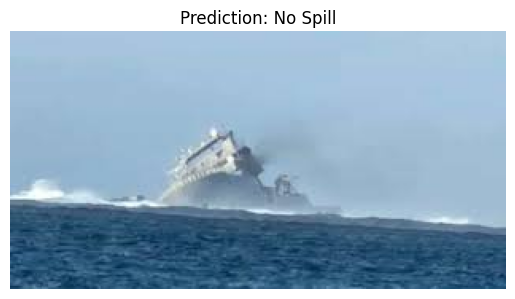

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_image(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    return prediction[0][0]

# Predict on uploaded image
img_path = f'/content/images (19).jfif'
prediction_prob = predict_image(model, img_path)

# Show result
if prediction_prob >= 0.5:
    print(f"🛢️ The image is predicted to be an OIL SPILL with {prediction_prob*100:.2f}% confidence.")
else:
    print(f"🌊 The image is predicted to be a NO SPILL with {(1 - prediction_prob)*100:.2f}% confidence.")

# Show image
img = image.load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {'Oil Spill' if prediction_prob >= 0.5 else 'No Spill'}")
plt.show()
